<a href="https://colab.research.google.com/github/anne-urai/ddm_mediation/blob/main/generate_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First, set Runtime -> Runtime type -> GPU for fitting

# https://hddm.readthedocs.io/en/latest/lan_tutorial.html
!pip install scikit-learn
!pip install cython
!pip install pymc

# after making changes to the hddm forked repo, factory reset runtime
!pip install -U --no-deps git+https://github.com/anne-urai/hddm
!pip install -U --no-deps git+https://github.com/hddm-devs/kabuki

# MODULE IMPORTS ----
# warning settings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# to download data
from google.colab import files
import pprint

# HDDM
import hddm

In [ ]:
##  ============================================================= ##
## generate some artificial choice data with mediation variable
##  ============================================================= ##

# first, previous choices ('X')
n_trials = int(1e4) # https://github.com/anne-urai/2019_Urai_choice-history-ddm/blob/master/simulations/1_ddm_rts.py#L84
n_subj = 20
df = pd.DataFrame(np.random.choice([-1,1], (n_trials*n_subj, 2)), columns=list('XS')) 

# then a normally distributed random variable, that depends on X
a_path = np.random.normal(size=n_subj)
M = []
for sjidx, (sj, sjdat) in enumerate(df.groupby(['subj_idx'])):
  M.append(np.random.normal(size=n_trials) + a_path[sjidx]
df['M'] = M


,subj_idx,trial_idx,S,X,M
6068,13,68,1,-1,-2.382062
3323,7,323,-1,1,1.266246
8182,17,182,1,-1,0.030706
5265,11,265,-1,-1,-1.200680
6213,13,213,-1,1,-0.998526
535,2,35,-1,1,1.913861
5205,11,205,1,-1,-1.639680
705,2,205,-1,1,2.827609
9894,20,394,1,-1,-0.855610
9071,19,71,-1,-1,0.323027


In [ ]:

for s in np.arange(n_subj):
  M = np.random.normal(size=n_trials) + df.loc['X']
  for n in np.arange(n_trials):
    subj_idx.append(s)
df['M'] = M

# make sure we have subj_idx and trial_idx
subj_idx = []
for s in np.arange(n_subj) + 1:
  for n in np.arange(n_trials):
    subj_idx.append(s)

trial_idx = []
for s in np.arange(n_subj) + 1:
  for n in np.arange(n_trials):
    trial_idx.append(n)

df['subj_idx'] = subj_idx
df['trial_idx'] = trial_idx

df = df[['subj_idx', 'trial_idx', 'S', 'X', 'M']]
df.sample(n=10)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmode

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: M          
No. Observations: 10000   Method:             REML       
No. Groups:       20      Scale:              0.9939     
Min. group size:  500     Likelihood:         -14222.8013
Max. group size:  500     Converged:          No         
Mean group size:  500.0                                  
----------------------------------------------------------
           Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept  -0.001     0.209  -0.007  0.994  -0.411   0.408
X           0.998     0.010  99.935  0.000   0.978   1.017
Group Var   0.873                                         



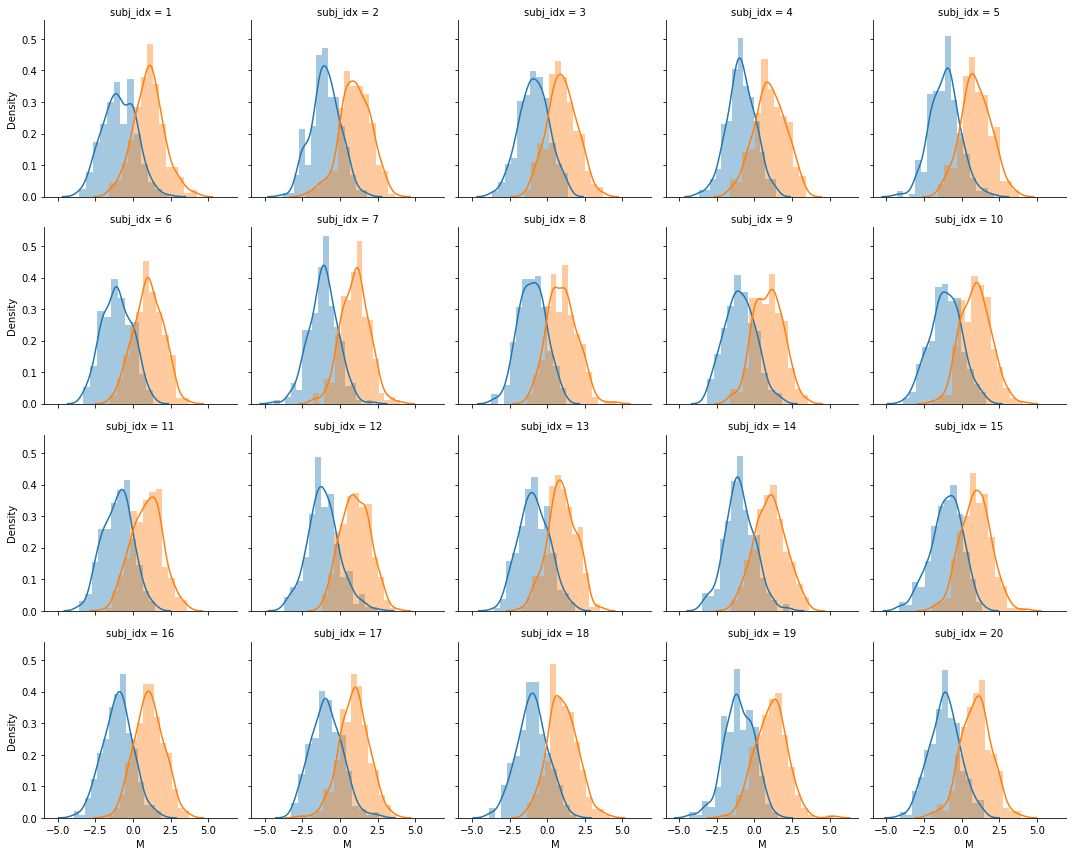

In [ ]:
# DOES M DEPEND ON X (a-path)?
import statsmodels.formula.api as smf

md = smf.mixedlm("M ~ X", df, groups=df["subj_idx"])
mdf = md.fit()
print(mdf.summary())

# see the separation
g = sns.FacetGrid(data=df, col='subj_idx', col_wrap=5, hue='X')
g.map(sns.distplot, 'M')

In [ ]:
##  ============================================================= ##
# plug into the HDDMnn simulator to simulate choices and RTs
##  ============================================================= ##

# help(hddm.simulators.hddm_dataset_generators.simulator_h_c)
# see https://hddm.readthedocs.io/en/latest/lan_tutorial.html#section-5-regressors 
# forum request for bug: https://groups.google.com/g/hddm-users/c/bdKDkwuQ3tk

for eff_x in ['v', 'no']: #'z', 'vz', 'no']:
  for eff_m in ['v', 'no']: # 'z', 'vz', 'no']:

  # simulate a couple of datasets: where X/M affects v/z/nothing
    regr_v = 'v ~ 1 + S'
    if 'v' in eff_x:
      regr_v = regr_v + ' + X'
    if 'v' in eff_m:
      regr_v = regr_v + ' + M'

    regr_z = 'z ~ 1'
    if 'z' in eff_x:
      regr_z = regr_z + ' + X'
    if 'z' in eff_m:
      regr_z = regr_z + ' + M'

    print(eff_x, '; ', 
          eff_m, '; ',
          regr_v, '; ',
          regr_z)

    # plug this into the simulator
    data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(data = df, 
                                                                                  model = 'ddm',
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None, 
                                                                                  depends_on = None, 
                                                                                  regression_models = [regr_v, regr_z], 
                                                                                  regression_covariates = ['S', 'X'],
                                                                                  group_only = None,
                                                                                  group_only_regressors = False,
                                                                                  fixed_at_default = None)

    # export the parameter_dict into df
    # from https://github.com/anne-urai/MEG/blob/master/hddm_funcs_plot.py#L66
    # https://github.com/anne-urai/hddm/blob/master/hddm/utils.py#L925
    param_dict = {}
    for key, value in full_parameter_dict.items():
        if 'reg' not in key:
            param_dict[key] = value
    param_dict
    param_df = pd.DataFrame.from_dict(param_dict, orient='index').reset_index()
    param_df = hddm.utils.results_long2wide(param_df, 
                                            name_col="index", 
                                            val_col=0)

    # save the data and param_df to files for later fitting
    # see https://colab.research.google.com/notebooks/io.ipynb#scrollTo=p2E4EKhCWEC5
    param_df.to_csv('param_df_X%s_M%s.csv'%(eff_x, eff_m))
    files.download('param_df_X%s_M%s.csv'%(eff_x, eff_m))

    data.to_csv('data_df_X%s_M%s.csv'%(eff_x, eff_m))
    files.download('data_df_X%s_M%s.csv'%(eff_x, eff_m))

v ;  v ;  v ~ 1 + S + X + M ;  z ~ 1
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

v ;  z ;  v ~ 1 + S + X ;  z ~ 1 + M
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Streaming output truncated to the last 5000 lines.
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bound

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

v ;  no ;  v ~ 1 + S + X ;  z ~ 1
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

z ;  v ;  v ~ 1 + S + M ;  z ~ 1 + X
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

z ;  z ;  v ~ 1 + S ;  z ~ 1 + X + M
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

z ;  vz ;  v ~ 1 + S + M ;  z ~ 1 + X + M
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where v